## SOFE3720 | FinalProject - Neighbourhoods in Toronto

## Table of Contents
* [Introduction](#introduction)
    * [Background](#background)
    * [Business Problem](#businessproblem)
* [Methodology](#methodology)
* [Data Sources](#data)



## **Introduction** <a name="introduction"></a>

**1.1. Background** <a name="background"></a> Toronto is the capital city of Ontario, the largest city in Canada and ranked as the fourth largest in North America. It’s a diverse city with a vast number of residing immigrants and is considered the most populous city in Canada. In 2020, Toronto had a metro area population of 6,197,000. Toronto is widely recognized as one of the most multicultural and cosmopolitan cities in the world and is an international hub for communications, business, arts and culture.

**1.2. Business Problem** <a name="businessproblem"></a> Toronto is generally a safe city to live in with a crime rate of 31% lower than the national average. Studies show that crime rates in Toronto increase when the unemployment rate is high. We want to be able to determine which neighborhoods in Toronto have low unemployment rates as those places will also have higher crime rates, so that the city can concentrate on the development of those neighborhoods and create more job opportunities which will decrease unemployment rate and crime rate.


## **Data Explanation & Data Source** <a name="introduction"></a>
1. Toronto Neighborhoods Dataset
 a. Wikipedia Toronto Postal Codes
 b. IBM Geospatial Coordinates
2. Neighborhood Crime Rates
3. Neighborhood Profiles Data


## **Methodology** <a name="methodology"></a>
This report aims to analyze the neighborhoods of Toronto city from different data sets and find the 
perfect spot. The following datasets will be utilized in the project: 

1) **Neighbourhoods Dataset:** This dataset contains neighborhood names as well as the geographic 
coordinates (latitude and longitude). The geographic coordinates will be used for two purposes; visualize 
Toronto map and call Foursquare API. 
 
2) **FourSquare:** Foursquare API is used to collect data to find the most common venues within a specific 
radius of a given geographic coordinate. 
 
3) **Neighborhood Profile Toronto:** This dataset contains the data for each of City of Toronto 
neighbourhoods. 
 
4) **Neighbourhood Crime Rates:** This dataset contains Crime Data by Neighbourhood. Data includes four- 
year averages and crime rates per 100,000 people by neighbourhood based on 2016 Census Population. 

5) **Wikipedia page to get more information about Toronto:** information we need to explore and cluster 
the  neighborhoods  in  Toronto.  You  will  scrape  the  Wikipedia  page,  wrangle,  and  clean  the  data,  and 
then read it into a pandas data frame. 

## **Data Sources** <a name="data"></a>


### Importing Libraries

The following csv files must be placed locally. This can be done by using a simple `wget` command to be able to access the required dataset.

In [183]:
%%capture
!wget -O GeoSpatial_Data https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs_v1/Geospatial_Coordinates.csv
!wget -O Neighbourhood_Profile https://ckan0.cf.opendata.inter.prod-toronto.ca/en_AU/datastore/dump/ef0239b1-832b-4d0b-a1f3-4153e53b189e?bom=True
!wget -O Crime_Data https://opendata.arcgis.com/datasets/af500b5abb7240399853b35a2362d0c0_0.csv
toronto_geo = 'Neighbourhoods.geojson'

The following dependencies and libraries will be required before going forward and making sure the following codes work properly.

In [184]:
import pandas as pd     # library for data analysis          
import numpy as np      # library to handle data in a vectorized manner
import plotly.express as px
import plotly.graph_objects as go

import folium           # library for map rendering
import requests         # library to handle request

from bs4 import BeautifulSoup as bs     
from geopy.geocoders import Nominatim   # Module to convert an address into latitude and longitude values

print("Libraries imported...")

Libraries imported...


## **1. Extracting Postal Code, Borough, Neighbourhood, Longitude, and, Latitude** <a name="extracting"></a>
### Scraping from Wikipedia page for Data
The table from the Wikipage has a list of all the Neighbourhoods in Toronto with the following Postal Code and associated Borough. It is scaped using and inserted into a dataframe using the code below:

In [185]:
# Requestion data from html url
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
html_table_data = requests.get(url).text 
soup = bs(html_table_data, 'html5lib')

# Create dataframe with following columns (Postal, Borough, Neighbourhood)
df = pd.DataFrame(columns = ['PostalCode','Borough','Neighbourhood'])
# Scrape the Wikipedia page for the rows in the table
tb_rows = soup.find('table').tbody.find_all('tr')       

# Filtering the scraped data and inserting to dataframe
for rows in tb_rows :
    for column in rows.find_all('td') :
        if column.span.text != 'Not assigned' :
            span  = column.span.text.split('(')
            df = df.append({'PostalCode' : column.b.text,
                              'Borough' : span[0],
                              'Neighbourhood' : span[1][:-1]}, ignore_index=True)

# Replace the following name of borough
df['Borough']=df['Borough'].replace({'Downtown TorontoStn A PO Boxes25 The Esplanade':'Downtown Toronto Stn A',
                                             'East TorontoBusiness reply mail Processing Centre969 Eastern':'East Toronto Business',
                                             'EtobicokeNorthwest':'Etobicoke Northwest','East YorkEast Toronto':'East York/East Toronto',
                                             'MississaugaCanada Post Gateway Processing Centre':'Mississauga'})

# Sort dataframe by PostalCode and reset to default indexing
df = df.sort_values('PostalCode').reset_index(drop = True)
df.head()   # print the first 5 in df

# df.shape    # shape/size of dataframe


,PostalCode,Borough,Neighbourhood
0,M1B,Scarborough,Malvern / Rouge
1,M1C,Scarborough,Rouge Hill / Port Union / Highland Creek
2,M1E,Scarborough,Guildwood / Morningside / West Hill
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


### Extracting Latitude and Longitude 
One of the download file (`GeoSpatial_Data`) from earlier will be used and inserted to a seperate dataframe.

In [186]:
%%capture   
# wget the following dataset and store locally
!wget -O GeoSpatial_Data https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs_v1/Geospatial_Coordinates.csv

In [187]:
geospatial_data = pd.read_csv('GeoSpatial_Data')                    # Read from the csv file
geospatial_data.columns = ['PostalCode', 'Latitude', 'Longitude']   # Set the columns
geospatial_data.head()   # print the first 5 in df

# geospatial_data.shape    # shape/size of dataframe


,PostalCode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


### Joining Dataframes based on Postal Code
We must clean the data first and seperate the neighbourhood into separate rows from the first dataframe, before continuing to join the two dataframes

In [188]:
# Cleaning data to split and splitting neighbourhoods
df = df.assign(Neighbourhood=df.Neighbourhood.str.split(" / ")).explode('Neighbourhood')

# Join both data based on PostalCode
df = df.join(geospatial_data.set_index('PostalCode'), on = 'PostalCode')        

df.head() # print the first 5 in df


,PostalCode,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,Malvern,43.806686,-79.194353
0,M1B,Scarborough,Rouge,43.806686,-79.194353
1,M1C,Scarborough,Rouge Hill,43.784535,-79.160497
1,M1C,Scarborough,Port Union,43.784535,-79.160497
1,M1C,Scarborough,Highland Creek,43.784535,-79.160497


## **2. Exploring Toronto Neighbourhoods on a Map** <a name="map"></a>
### Creating Clustered Map of Toronto Neighbourhoods

In [189]:
df.Borough.value_counts()      # return most frequent-occuring Borough (most neighbourhood)

Etobicoke                 44
Scarborough               38
North York                36
Downtown Toronto          35
Central Toronto           16
West Toronto              13
Etobicoke Northwest        9
York                       8
East Toronto               6
East York                  5
East York/East Toronto     1
Downtown Toronto Stn A     1
Queen's Park               1
Mississauga                1
East Toronto Business      1
Name: Borough, dtype: int64

In [190]:
# Use geopy library to get the latitude and longitude values of Toronto city
address = 'Toronto, Ontario'
geolocator = Nominatim(user_agent = 'ny_explorer')
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

print('Geographical Coordinates of Toronto City:')
print('Latitude: ', latitude)
print('Longitude: ', longitude)

Geographical Coordinates of Toronto City:
Latitude:  43.6534817
Longitude:  -79.3839347


In [191]:
MAPBOX_ACCESSTOKEN='pk.eyJ1IjoiamVzcy1kYXRhIiwiYSI6ImNraGxzcTE0MzFibDIycHFrZHV0ZzIwejYifQ.rmOTEpw-SZSoQO4cnUuEIg'

Using Folium library we are able to create a map of Toronto using the aquired latitude and longitude values. Neighbourhoods can be mapped out from their coordinate values, as seen on the map below with the blue coloured dots.

In [192]:
# Array of Toronto boroughs
borough_array = ['North York', 'York ', 'East York', 'Downtown Toronto', 'Central Toronto', 'West Toronto', 'East Toronto', 'Downtown Toronto Stn A' , 'East Toronto Business', 'East York/East Toronto', 'Scarborough',
                 'Etobicoke', 'Etobicoke Northwest', "Queen's Park", 'Mississauga']

# Make changes in the dataframe accordingly
df1 = df.copy()
for boroughs in borough_array :
    for borough in boroughs :
        df1.replace(borough, str(boroughs), inplace = True)

colors_array = np.empty(15, dtype = str)
colors_array.fill('blue')

# cCeate map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# Add markers to map
for borough, color in zip(borough_array, colors_array) :
    df2 = df1[df1.Borough == str(borough)]
    for lat, lng, borough, neighborhood in zip(df2['Latitude'], df2['Longitude'], df2['Borough'], df2['Neighbourhood']):
        label = '{}, {}'.format(neighborhood, borough)
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius = 5,
            popup = label,
            color = 'blue',
            fill = True,
            fill_color = 'blue',
            fill_opacity = 1,
            parse_html = False).add_to(map_toronto)  
    
map_toronto


## **3. Correlation Between *'Crime Rate Vs. Unemployment, House Income, and Age Population'* in Toronto Neighbourhoods** <a name="correlation"></a>

### Neighbourhood Profiles
The following dataset shows detailed information about each neighbourhood in Toronto. This includes age, income, education, unemployment rate, and more. We will read this dataset from the one of the downloaded files from earlier.

In [193]:
%%capture   
# wget dataset and store locally
!wget -O Neighbourhood_Profile https://ckan0.cf.opendata.inter.prod-toronto.ca/en_AU/datastore/dump/ef0239b1-832b-4d0b-a1f3-4153e53b189e?bom=True

In [194]:
# Obtain the row number for "Unemployment" to allow us extract it from the dataframe
neighbourhood_profile = pd.read_csv('Neighbourhood_Profile')
neighbourhood_profile.head()

,_id,Category,Topic,Data Source,Characteristic,City of Toronto,Agincourt North,Agincourt South-Malvern West,Alderwood,Annex,...,Willowdale West,Willowridge-Martingrove-Richview,Woburn,Woodbine Corridor,Woodbine-Lumsden,Wychwood,Yonge-Eglinton,Yonge-St.Clair,York University Heights,Yorkdale-Glen Park
0,1,Neighbourhood Information,Neighbourhood Information,City of Toronto,Neighbourhood Number,NaN,129,128,20,95,...,37,7,137,64,60,94,100,97,27,31
1,2,Neighbourhood Information,Neighbourhood Information,City of Toronto,TSNS2020 Designation,NaN,No Designation,No Designation,No Designation,No Designation,...,No Designation,No Designation,NIA,No Designation,No Designation,No Designation,No Designation,No Designation,NIA,Emerging Neighbourhood
2,3,Population,Population and dwellings,Census Profile 98-316-X2016001,"Population, 2016","2,731,571","29,113","23,757","12,054","30,526",...,"16,936","22,156","53,485","12,541","7,865","14,349","11,817","12,528","27,593","14,804"
3,4,Population,Population and dwellings,Census Profile 98-316-X2016001,"Population, 2011","2,615,060","30,279","21,988","11,904","29,177",...,"15,004","21,343","53,350","11,703","7,826","13,986","10,578","11,652","27,713","14,687"
4,5,Population,Population and dwellings,Census Profile 98-316-X2016001,Population Change 2011-2016,4.50%,-3.90%,8.00%,1.30%,4.60%,...,12.90%,3.80%,0.30%,7.20%,0.50%,2.60%,11.70%,7.50%,-0.40%,0.80%


The dataset `Neighbourhood_Profile` is large dataset of Toronto Neighbourhoods with the shape/size of:


In [195]:
neighbourhood_profile.shape     # return shape of dataset

(2383, 146)

### **PART 1 - Crime Rate (2019)**

From the dataset downloaded in the beginning (`Crime_Data`) we are able to find the types of Crime Rates in each neighbourhoods

In [196]:
%%capture
# wget the dataset and store it locally
!wget -O Crime_Data https://opendata.arcgis.com/datasets/af500b5abb7240399853b35a2362d0c0_0.csv

In [197]:
# Read from the csv data file
crime_data = pd.read_csv('Crime_Data')          

# Filter crime data to extract the following column
crime_data = crime_data[["Neighbourhood", "Hood_ID", "Population", 
                        "Assault_Rate_2019", "AutoTheft_Rate_2019", 
                        "BreakandEnter_Rate_2019", "Homicide_Rate_2019", 
                        "Robbery_Rate_2019", "TheftOver_Rate_2019"]]

# Rename Columns 
crime_data.rename(columns={'Hood_ID':'Neighbourhood ID'},inplace=True)
crime_data.rename(columns={'Assault_Rate_2019':'Assault Rate'},inplace=True)
crime_data.rename(columns={'AutoTheft_Rate_2019':'AuthoTheft Rate'},inplace=True)
crime_data.rename(columns={'BreakandEnter_Rate_2019':'BreakAndEnter Rate'},inplace=True)
crime_data.rename(columns={'Homicide_Rate_2019':'Homicide Rate'},inplace=True)
crime_data.rename(columns={'Robbery_Rate_2019':'Robbery Rate'},inplace=True)
crime_data.rename(columns={'TheftOver_Rate_2019':'TheftOver Rate'},inplace=True)

# Merge data based on Neighbourhood
# df = df.merge(crime_data.set_index('Neighbourhood'), on = 'Neighbourhood')

crime_data.head() # print the first 5 rows in df

,Neighbourhood,Neighbourhood ID,Population,Assault Rate,AuthoTheft Rate,BreakAndEnter Rate,Homicide Rate,Robbery Rate,TheftOver Rate
0,Yonge-St.Clair,97,12528,295.3,47.9,223.5,0.0,31.9,47.9
1,York University Heights,27,27593,1340.9,521.9,391.4,0.0,286.3,101.5
2,Lansing-Westgate,38,16164,445.4,198.0,241.3,0.0,68.1,68.1
3,Yorkdale-Glen Park,31,14804,1411.8,412.1,567.4,6.8,283.7,195.9
4,Stonegate-Queensway,16,25051,327.3,135.7,255.5,0.0,87.8,16.0


To get the total crime rate we must sum up all the different types of crime rate

In [198]:
# declare which column to deal with
columns = ["Assault Rate", "AuthoTheft Rate", "BreakAndEnter Rate", "Homicide Rate", "Robbery Rate", "TheftOver Rate"]

crime_data['Total Crime Rate'] = crime_data[columns].sum(axis=1)    # sum up all rates to find total
crime_data.drop(columns, axis=1, inplace=True)                      # drop columns 

crime_data.head() # print the first 5 rows in df

,Neighbourhood,Neighbourhood ID,Population,Total Crime Rate
0,Yonge-St.Clair,97,12528,646.5
1,York University Heights,27,27593,2642.0
2,Lansing-Westgate,38,16164,1020.9
3,Yorkdale-Glen Park,31,14804,2877.7
4,Stonegate-Queensway,16,25051,822.3


### **PART  2 - Unemployment Rate (2016)**

We can extract the Unemployment Rate from the following dataset (`Neighbourhood Profile`)

In [199]:
# Slice demographics dataframe to obtain "Unemployment" per Neighbourhood
neighbourhood_profile.index[neighbourhood_profile['Characteristic'] == 'Unemployment rate'].tolist()
slice_neighbourhood_profile = neighbourhood_profile.iloc[lambda df: [0, 1890], 4:]
slice_neighbourhood_profile.head()

,Characteristic,City of Toronto,Agincourt North,Agincourt South-Malvern West,Alderwood,Annex,Banbury-Don Mills,Bathurst Manor,Bay Street Corridor,Bayview Village,...,Willowdale West,Willowridge-Martingrove-Richview,Woburn,Woodbine Corridor,Woodbine-Lumsden,Wychwood,Yonge-Eglinton,Yonge-St.Clair,York University Heights,Yorkdale-Glen Park
0,Neighbourhood Number,NaN,129,128,20,95,42,34,76,52,...,37,7,137,64,60,94,100,97,27,31
1890,Unemployment rate,8.2,9.8,9.8,6.1,6.7,7.2,7.2,10.2,7.7,...,9.8,8.5,10.6,7.7,6.6,5.2,6.9,5.9,10.7,8


Cleaning up data...

In [200]:
# Drop irrelevant columns
slice_neighbourhood_profile.drop(labels='City of Toronto',axis=1, inplace=True)
slice_neighbourhood_profile.rename(columns={'Characteristic':'Neighbourhood'}, inplace=True)
# Set index and Transpose
slice_neighbourhood_profile=slice_neighbourhood_profile.set_index('Neighbourhood').T
slice_neighbourhood_profile.reset_index(inplace = True)
# Re-order columns
slice_neighbourhood_profile.columns = ['Neighbourhood', 'Neighbourhood ID', 'Unemployment Rate']
# Set Neighbourhood ID and Unemployment Rate to numeric type
slice_neighbourhood_profile['Neighbourhood ID']=slice_neighbourhood_profile['Neighbourhood ID'].apply(pd.to_numeric) 
slice_neighbourhood_profile['Unemployment Rate']=slice_neighbourhood_profile['Unemployment Rate'].apply(pd.to_numeric) 
slice_neighbourhood_profile.head()

,Neighbourhood,Neighbourhood ID,Unemployment Rate
0,Agincourt North,129,9.8
1,Agincourt South-Malvern West,128,9.8
2,Alderwood,20,6.1
3,Annex,95,6.7
4,Banbury-Don Mills,42,7.2


### **PART 3 - Household Income (2015)**

We can extract the Household Income from the following dataset (`Neighbourhood Profile`)

In [201]:
# Obtain the row number for "Household Income" to allow us extract it from the dataframe
neighbourhood_profile.index[neighbourhood_profile['Characteristic'] == ('  Average after-tax income of households in 2015 ($)', 
                                                                        'Total - Household after-tax income groups in 2015 for private households - 100% data',
                                                                        '  Under $5,000',
                                                                        '  $5,000 to $9,999',
                                                                        '  $10,000 to $14,999',
                                                                        '  $20,000 to $24,999',
                                                                        '  $25,000 to $29,999',
                                                                        '  $30,000 to $34,999',
                                                                        '  $35,000 to $39,999',
                                                                        '  $40,000 to $44,999',
                                                                        '  $45,000 to $49,999',
                                                                        '  $50,000 to $59,999',
                                                                        '  $60,000 to $69,999',
                                                                        '  $70,000 to $79,999',
                                                                        '  $80,000 to $89,999',
                                                                        '  $90,000 to $99,999',
                                                                        '  $100,000 and over',
                                                                        'Total - Low-income status in 2015 for the population in private households to whom low-income concepts are applicable - 100% data'
                                                                        )].tolist()

[]

In [202]:
# Slice demographics dataframe to obtain "Household Income" per Neighbourhood
income_data=neighbourhood_profile.iloc[lambda df: [0,1029, 1054,1055,1056,1057,1058,1059,1060,1061,1062,1063,1064,1065,1066,1067,1068,1069,1119], 4:]
income_data.head()

,Characteristic,City of Toronto,Agincourt North,Agincourt South-Malvern West,Alderwood,Annex,Banbury-Don Mills,Bathurst Manor,Bay Street Corridor,Bayview Village,...,Willowdale West,Willowridge-Martingrove-Richview,Woburn,Woodbine Corridor,Woodbine-Lumsden,Wychwood,Yonge-Eglinton,Yonge-St.Clair,York University Heights,Yorkdale-Glen Park
0,Neighbourhood Number,NaN,129,128,20,95,42,34,76,52,...,37,7,137,64,60,94,100,97,27,31
1029,Average after-tax income of households in 20...,"81,495","427,037","278,390","168,602","792,507","493,486","251,583","352,218","354,894",...,"272,986","412,302","629,030","240,272","147,462","239,484","222,648","541,217","302,358","213,860"
1054,Total - Household after-tax income groups in 2...,"1,112,930","9,115","8,140","4,620","15,940","12,125","6,090","15,070","9,525",...,"7,550","8,510","18,430","5,455","3,450","5,880","5,680","7,010","10,165","5,345"
1055,"Under $5,000","34,795",150,320,70,905,300,130,"2,545",610,...,575,105,435,70,60,135,215,240,350,115
1056,"$5,000 to $9,999","23,615",105,130,35,485,150,85,740,255,...,215,80,470,125,60,125,105,125,220,70


Cleaning up data...

In [203]:
# Drop irrelevant columns
income_data.rename(columns={'Characteristic':'Neighbourhood'}, inplace=True)
# Set index and Transpose
income_data=income_data.set_index('Neighbourhood').T
income_data.reset_index(inplace = True)
# Re-order columns
income_data.columns = ['Neighbourhood', 
                        'Neighbourhood ID', 
                        'Household After Tax Income', 
                        'Total Household Income Group',
                        'Under $5,000', 
                        '$5,000 to $9,999', 
                        '$10,000 to $14,999',
                        '$20,000 to $24,999',
                        '$25,000 to $29,999',
                        '$30,000 to $34,999',
                        '$35,000 to $39,999',
                        '$40,000 to $44,999',
                        '$45,000 to $49,999',
                        '$50,000 to $59,999',
                        '$60,000 to $69,999',
                        '$70,000 to $79,999',
                        '$80,000 to $89,999',
                        '$90,000 to $99,999',
                        '$100,000 and over',
                        'Low Income Status']
# Set Neighbourhood ID and Unemployment Rate to numeric type

income_data.head()

,Neighbourhood,Neighbourhood ID,Household After Tax Income,Total Household Income Group,"Under $5,000","$5,000 to $9,999","$10,000 to $14,999","$20,000 to $24,999","$25,000 to $29,999","$30,000 to $34,999","$35,000 to $39,999","$40,000 to $44,999","$45,000 to $49,999","$50,000 to $59,999","$60,000 to $69,999","$70,000 to $79,999","$80,000 to $89,999","$90,000 to $99,999","$100,000 and over",Low Income Status
0,City of Toronto,NaN,"81,495","1,112,930","34,795","23,615","37,080","55,930","51,910","52,205","53,515","55,545","55,770","53,385","98,910","86,755","75,120","63,360","51,570","344,855"
1,Agincourt North,129,"427,037","9,115",150,105,165,450,340,565,450,510,455,475,930,755,695,640,500,"1,305"
2,Agincourt South-Malvern West,128,"278,390","8,140",320,130,205,275,350,415,395,450,470,445,860,755,630,500,405,"1,125"
3,Alderwood,20,"168,602","4,620",70,35,80,85,160,175,170,210,185,225,390,355,365,310,265,"1,345"
4,Annex,95,"792,507","15,940",905,485,660,785,680,625,630,675,645,665,"1,160","1,060",820,750,620,"7,995"


## **4. Results - Cluster Data** <a name="results"></a>

### Cluster 1 - Crime Rate Vs. Unemployment Rate Vs. Population

In [204]:
cluster_data1 = pd.merge(crime_data, slice_neighbourhood_profile, on = ['Neighbourhood'])

# drop duplicate column
column = ["Neighbourhood ID_y"]       
cluster_data1.rename(columns={'Neighbourhood ID_x':'Neighbourhood ID'},inplace=True)
cluster_data1.drop(column, axis=1, inplace=True)  

cluster_data1.head()

,Neighbourhood,Neighbourhood ID,Population,Total Crime Rate,Unemployment Rate
0,Yonge-St.Clair,97,12528,646.5,5.9
1,York University Heights,27,27593,2642.0,10.7
2,Lansing-Westgate,38,16164,1020.9,7.2
3,Yorkdale-Glen Park,31,14804,2877.7,8.0
4,Stonegate-Queensway,16,25051,822.3,6.7


### Cluster 2 - Crime Rate Vs. Unemployment Rate Vs. Low Income Status

In [205]:
# column = ["Neighbourhood", "Low Income Status", "Household After Tax Income"]
column = ["Neighbourhood", "Low Income Status"]

house_income = income_data[column]
cluster_data2 = pd.merge(cluster_data1, house_income, on = ['Neighbourhood'])
# cluster_data2['Household After Tax Income'] = cluster_data2['Household After Tax Income'].str.replace(r',', '').astype(int)
cluster_data2['Low Income Status'] = cluster_data2['Low Income Status'].str.replace(r',', '').astype(int)


cluster_data2

,Neighbourhood,Neighbourhood ID,Population,Total Crime Rate,Unemployment Rate,Low Income Status
0,Yonge-St.Clair,97,12528,646.5,5.9,4220
1,York University Heights,27,27593,2642.0,10.7,700
2,Lansing-Westgate,38,16164,1020.9,7.2,4070
3,Yorkdale-Glen Park,31,14804,2877.7,8.0,1130
4,Stonegate-Queensway,16,25051,822.3,6.7,5860
...,...,...,...,...,...,...
131,Milliken,130,26572,1392.6,9.5,1155
132,Pleasant View,46,15818,625.9,10.0,1125
133,Wychwood,94,14349,961.7,5.2,2080
134,Leaside-Bennington,56,16828,689.4,6.9,7965


## **5. Results - Plotting Cluster Data** <a name="results"></a>

### **Bubble Plot** for Cluster Data #1

In [206]:
column = ["PostalCode", "Latitude", "Longitude"]        #drop unecessary column
df.drop(column, axis=1, inplace=True) 

# merge two tables based on neighbourhood
bubble_data = pd.merge(cluster_data1,df, on='Neighbourhood')
bubble_data.head()

,Neighbourhood,Neighbourhood ID,Population,Total Crime Rate,Unemployment Rate,Borough
0,The Beaches,63,21567,848.5,5.7,East Toronto
1,Thorncliffe Park,55,21108,819.6,12.6,East York
2,Humewood-Cedarvale,106,14365,710.0,7.1,York
3,Scarborough Village,139,16724,1572.6,13.0,Scarborough
4,Humber Summit,21,12416,2923.7,9.6,North York


In [207]:
bubble_chart = px.scatter(bubble_data,              # Dataframe
                        x="Unemployment Rate",      # Column name for x-values
                        y="Total Crime Rate",       # Column name for y-values
                        size="Population",          # column name for size of bubble
                        color="Borough",            # Column name for Legend
                        hover_data=({
                        'Unemployment Rate': ':.2f', # Set the no. of decimal places
                        'Total Crime Rate': ':.2f',
                        'Population': ':.2f'}),
                        hover_name="Neighbourhood",
                        size_max=45,                 # maximum bubble size
                        title='Toronto Neighbourhoods - Crime Rate Vs. Unemployment Rate')

bubble_chart.update_layout(width=800, height=600,)
bubble_chart.show()

### **Column Chart** for Cluster Data #2

Adding the Household Income to the Cluster we can further examine each neighbourhood

In [208]:
# merge two tables based on neighbourhood
column_data = pd.merge(cluster_data2, df, on='Neighbourhood')
column_data.head()

,Neighbourhood,Neighbourhood ID,Population,Total Crime Rate,Unemployment Rate,Low Income Status,Borough
0,The Beaches,63,21567,848.5,5.7,7605,East Toronto
1,Thorncliffe Park,55,21108,819.6,12.6,445,East York
2,Humewood-Cedarvale,106,14365,710.0,7.1,3380,York
3,Scarborough Village,139,16724,1572.6,13.0,695,Scarborough
4,Humber Summit,21,12416,2923.7,9.6,355,North York


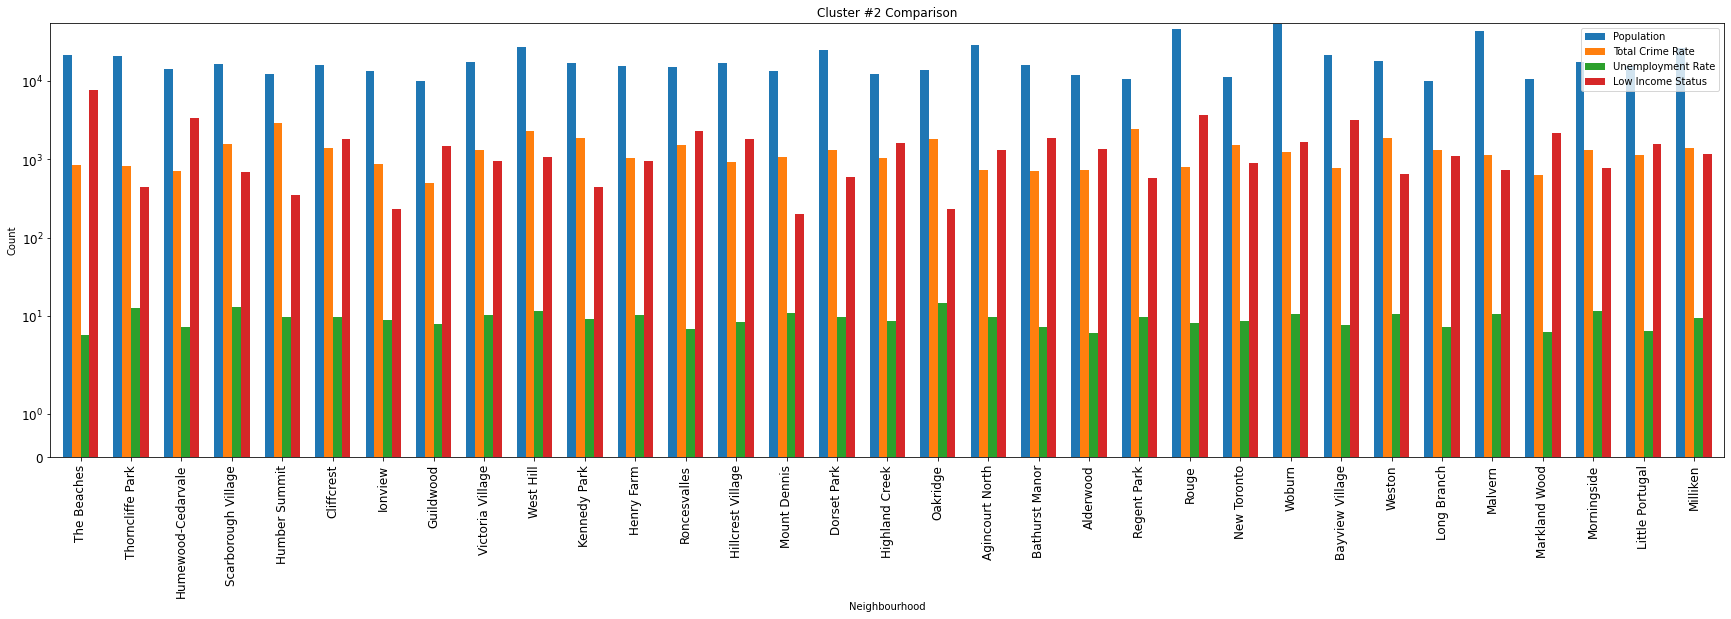

In [209]:
col_chart = column_data.plot(x='Neighbourhood',
                            y=['Population', 'Total Crime Rate', 'Unemployment Rate', 'Low Income Status'],
                            kind='bar',
                            title='Cluster #2 Comparison',
                            fontsize=12,
                            figsize=(30,8),
                            width=0.7)
col_chart.set_ylabel('Count')
col_chart.set_yscale('symlog')

In [214]:
# Copy orignal dataframe
cluster_map=cluster_data1.copy(deep=True)
# Rename Columns. This is not necessary
cluster_map.columns=['Neighbourhood','Neighbourhood ID','Population','Crime_Rate','Unemployment_Rate']
# Set index to Neighbourhood ID. Same as GeoJSON dataset
cluster_map=cluster_map.set_index('Neighbourhood ID')

In [216]:
# Initialize Layout
final_map = go.Figure()

# Add Traces

# Population
final_map.add_trace(
    go.Choroplethmapbox(
        geojson=toronto_geo,
        locations=cluster_map.index,  
        z=cluster_map.Population,
        text=cluster_map.Neighbourhood,
        colorbar=dict(thickness=20,
                      ticklen=3,
                      outlinewidth=0,
                      title="Population"),
        marker_line_width=1,
        marker_opacity=1,
        colorscale="YlOrRd",
        hovertemplate="<b>%{text}</b><br>" + "Population: %{z}<br>" +
        "<extra></extra>",
        visible=False))

# Crime rate
final_map.add_trace(
    go.Choroplethmapbox(
        geojson=toronto_geo,
        locations=cluster_map.index,  
        z=cluster_map.Crime_Rate,
        text=cluster_map.Neighbourhood,
        colorbar=dict(thickness=20,
                      ticklen=3,
                      outlinewidth=0,
                      title="Crime Rate"),
        marker_line_width=1,
        marker_opacity=1,
        colorscale="YlOrRd",
        hovertemplate="<b>%{text}</b><br>" + "Crime Rate: %{z}<br>" +
        "<extra></extra>",
        visible=False))

# Unemployment Rate
final_map.add_trace(
    go.Choroplethmapbox(
        geojson=toronto_geo,
        locations=cluster_map.index,  
        z=cluster_map.Unemployment_Rate,
        text=cluster_map.Neighbourhood,
        colorbar=dict(thickness=20,
                      ticklen=3,
                      outlinewidth=0,
                      title="Unemployment Rate"),
        marker_line_width=1,
        marker_opacity=1,
        colorscale="YlOrRd",
        hovertemplate="<b>%{text}</b><br>" + "Unemployment Rate: %{z}<br>" +
        "<extra></extra>",
        visible=False))

# Create drop-down menus for all the datasets
final_map.update_layout(
    updatemenus=[
        dict(
            type="dropdown", # set type of menu
            direction="down", # set direction of dropdown menu
            showactive=True, # Show the selected label
            x=0.75, # set horizontal position of the menu
            xanchor="left", # refernce point for x position
            y=1.0, # set vertical position of the menu
            yanchor="top", # refernce point for y position
            buttons=list([
                dict(
                    label="Population",
                    method="update",
                    args=[{
                        "visible": [True, False, False]
                    }, {
                        "title":
                        "Population in Toronto Neighbourhoods (per 100,000 people)"
                    }]),
                dict(
                    label="Crime Rate",
                    method="update",
                    args=[{
                        "visible": [False, True, False]
                    }, {
                        "title":
                        "Crime Rate in Toronto Neighbourhoods (per 100,000 people)"
                    }]),
                dict(
                    label="Unemployment Rate",
                    method="update",
                    args=[{
                        "visible": [False, False, True]
                    }, {
                        "title":
                        "Unemployment Rate in Toronto Neighbourhoods (per 100,000 people)"
                    }]),
                dict(label="Clear All",
                     method="update",
                     args=[{
                         "visible": [False, False, False]
                     }, {
                         "title": "Toronto Neighbourhoods"
                     }])
            ])),
 
# Menu options for Map styles
        dict(type="dropdown",
             direction="up",
             showactive=True,
             x=0.75,
             xanchor='left',
             y=0.0,
             yanchor='bottom',
             buttons=list([
                 dict(args=['mapbox.style', 'dark'],
                      label='Dark',
                      method='relayout'),
                 dict(args=['mapbox.style', 'light'],
                      label='Light',
                      method='relayout'),
                 dict(args=['mapbox.style', 'satellite'],
                      label='Satellite',
                      method='relayout'),
                 dict(args=['mapbox.style', 'streets'],
                      label='Streets',
                      method='relayout')
             ]))
    ],
    title={
        'text': f"Toronto Neighbourhoods Population Index", # Inital plot title
        'font': {'size': 20},
        'xanchor': 'left'}, 
    mapbox1=dict(domain={'x': [0, 1], 'y': [0, 1]},
                 center=dict(lat=latitude, lon=longitude),
                 accesstoken=MAPBOX_ACCESSTOKEN,
                 zoom=9.5,
                 bearing=-12),
    margin=dict(l=0, r=0, t=40, b=0))

final_map.show()